In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import CoolProp.CoolProp as cp
import pandas as pd
import scipy
%pip install openpyxl

/Users/wdugan/.zshenv:1: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:2: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:3: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:4: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:5: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:6: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:7: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:8: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:9: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:10: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:11: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:12: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv:13: no such file or directory: /opt/homebrew/bin/brew
/Users/wdugan/.zshenv

In [2]:
#Constants
molar_mass_water = 18.01528e-3  # [kg/mol]
Tc = cp.PropsSI('T_critical', 'water')  # [K]
temp_arr = np.arange(274, 648) #[K]

### 2a

Vi importerer eksperimentell data fra excel ark ved hjelp av pandas sin `pd.read_excel`. Den tar inn blant annet en path til filen, hvilket ark i filen den skal lese fra og om den har en tittel.

In [3]:
file_path = "WaterVolume.xlsx"

dataVV = pd.read_excel(file_path, sheet_name="Vv", header=None) #V_v [cm^3/g]
#Source: https://www.engineeringtoolbox.com/water-specific-volume-weight-d_661.html

dataTVV = pd.read_excel(file_path, sheet_name="T_vv", header=None) #T [Celsius]
#Source: https://www.engineeringtoolbox.com/water-specific-volume-weight-d_661.html

dataL = pd.read_excel(file_path, sheet_name="L", header=None) #L [kJ/kg]
#Source: https://www.engineeringtoolbox.com/water-properties-d_1573.html

dataTL = pd.read_excel(file_path, sheet_name="T", header=None) #T [Celsius]
#Source: https://www.engineeringtoolbox.com/water-properties-d_1573.html

dataVg = pd.read_excel(file_path, sheet_name="Vg", header=None) #V_g [g/L]
#Source: https://www.engineeringtoolbox.com/water-properties-temperature-equilibrium-pressure-d_2099.html

dataTg = pd.read_excel(file_path, sheet_name="Tg", header=None) #T_g [K]
#Source: https://www.engineeringtoolbox.com/water-properties-temperature-equilibrium-pressure-d_2099.html

In [4]:
#Convert to np.ndarray 
Vv_ = dataVV.to_numpy(dtype=float).reshape(37)
T_Vv = dataTVV.to_numpy(dtype=float).reshape(37)
L_ = dataL.to_numpy(dtype=float).reshape(35)
T_L = dataTL.to_numpy(dtype=float).reshape(35)
Vg_ = dataVg.to_numpy(dtype=float).reshape(20)
T_Vg_exp = dataTg.to_numpy(dtype=float).reshape(20)

#Konverter til Kelvin
T_L_exp = T_L + 273.15
T_Vv_exp = T_Vv + 273.15
#Konverter til L
Vv_exp = Vv_ * molar_mass_water
Vg_exp = molar_mass_water*1.0E3/Vg_
#Konverter til J
L_exp = molar_mass_water*1.0E3*L_

### 2b

For å finne en regresjonslinje til den eksperimentelle dataen, kan vi bruke `scipy.optimize.curve_fit`. Modellene vi sender inn for $V_v$ og $V_g$ har vi funnet ved å teste ulike funksjonstyper og se hva som passer best. Modellen for $L$ kommer fra Clayperons likning, der vi kan se at $L$ er proporsjonal med $T$. Best mulig proporsjonalitet er videre funnet ved å prøve og feile. 

In [5]:
#Modeller for regresjon
def modelVv(x, a, b, c, d):
    return a*x**6 + b*x**4 + c*x**2 + d

def modelVg(x, a, b):
    return a*np.exp(b/x)

def modelL(x, a, b):
    return b*(np.abs(x-Tc))**a  

In [6]:
#Henter ut koeffisientene som skal inn som parametere i modellfunksjonene
paramsVV, _ = scipy.optimize.curve_fit(modelVv, T_Vv_exp, Vv_exp)
paramsVG, _ = scipy.optimize.curve_fit(modelVg, T_Vg_exp, Vg_exp)
paramsL, _ = scipy.optimize.curve_fit(modelL, T_L_exp, L_exp)

/var/folders/wy/n9xc5k0n7d1d1tk7_xq212hh0000gp/T/ipykernel_55509/2136660678.py:9: RuntimeWarning: divide by zero encountered in power
  return b*(np.abs(x-Tc))**a


In [7]:
# Definerer interpolerte funksjoner
def Vv(T):
    a, b, c, d = paramsVV
    return a * T ** 6 + b * T ** 4 + c * T ** 2 + d

def Vg(T):
    a, b = paramsVG
    return a * np.exp(b / T)

def L(T):
    a, b = paramsL
    return b * (np.abs(T - Tc)) ** a

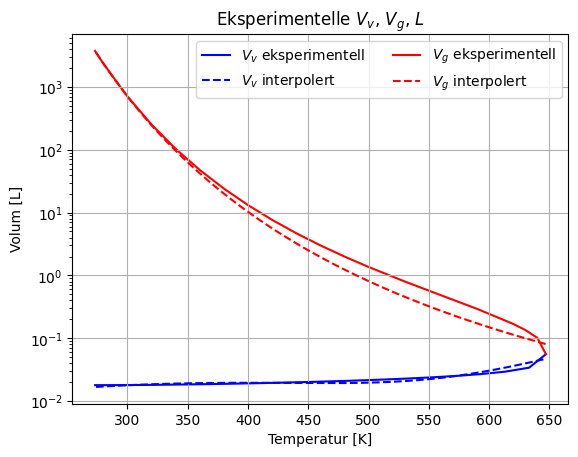

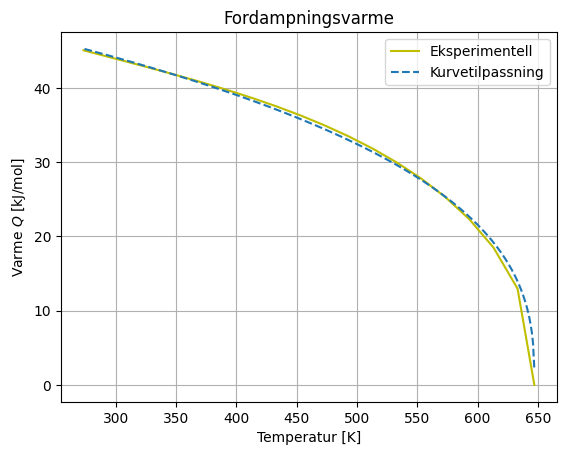

In [8]:
temp_arr = np.arange(274, 648)

#Plotter spesifikt volum av vann som funksjon av temperatur
plt.semilogy(T_Vv_exp, Vv_exp, label=r"$V_v$ eksperimentell", c='b', ls='-', zorder=1)
plt.semilogy(temp_arr, Vv(temp_arr), label=r"$V_v$ interpolert", c='b', ls='--', zorder=2)

#Plotter spesifikt volum av vanndamp som funksjon av temperatur
plt.semilogy(T_Vg_exp, Vg_exp, label=r"$V_g$ eksperimentell", color='r', ls='-', zorder=1)
plt.semilogy(temp_arr, Vg(temp_arr), label=r"$V_g$ interpolert", c='r', ls='--', zorder=2)

plt.xlabel("Temperatur [K]")
plt.ylabel("Volum [L]")
plt.title('Eksperimentelle $V_v$, $V_g$, $L$')
plt.legend(ncol=2)
plt.grid()
plt.show()

#Plotter fordampningsvarme som funksjon av temperatur
plt.plot(T_L_exp, L_exp*1e-3, label="Eksperimentell", color='y')
plt.plot(temp_arr, L(temp_arr)*1e-3, label="Kurvetilpassning", ls='--')
plt.title("Fordampningsvarme")
plt.xlabel("Temperatur [K]")
plt.ylabel("Varme $Q$ [kJ/mol]")
plt.legend()
plt.grid()
plt.show()

### 2c

Vi ønsker nå å integrere likning (13) ved hjelp av Simpsons metode. Vi starter med å definere en funksjon for å kunne integrere.

In [9]:
def simpsons(f, a, b, n=100):
    """ 
    Integrasjon med Simpsons metode.

    Parametere
    ----------
    f : funksjon f(x) -> float
    a : float
        Startverdi (nedre endepunkt).
    b : float
        Sluttpunkt (øvre endepunkt).
    n : int
        Antall disktrete punkter mellom a og b. Standard 100.

    Returnerer
    ----------
    float : integrasjonsestimat
    """
    x, dx = np.linspace(a, b, n+1, retstep=True)
    sol = dx / 3 * (
        f(x[0]) + 2 * np.sum(f(x[:n-2:2])) + 4 * np.sum(f(x[1:n-1:2])) + f(x[n])
    )
    return sol


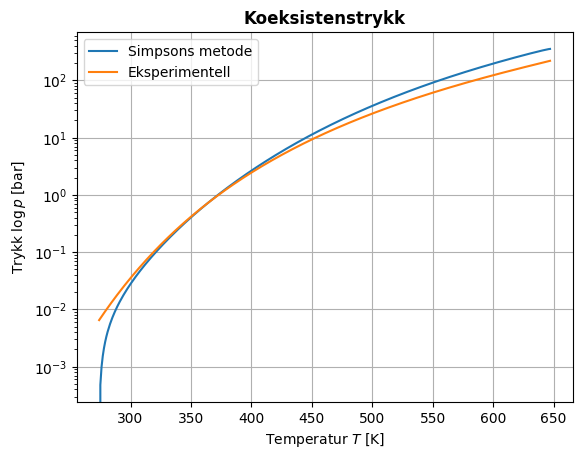

In [10]:
def dp(T):
    """ dp i bar """
    return 1e3 * L(T) / (T * (Vg(T) - Vv(T)))

vapor_pressure_exp = np.asarray([cp.PropsSI('P', 'T|twophase', t, 'Q', 0, 'Water') for t in temp_arr])
p_clapeyron = [simpsons(dp, 274, t)*1e-5 for t in temp_arr]  # [bar]

plt.semilogy(temp_arr, p_clapeyron, label="Simpsons metode")
plt.semilogy(temp_arr, vapor_pressure_exp*1e-5, label='Eksperimentell')
plt.xlabel('Temperatur $T$ [K]')
plt.ylabel('Trykk $\log p$ [bar]')
plt.title('Koeksistenstrykk', weight='bold')
plt.legend()
plt.grid()
plt.show()

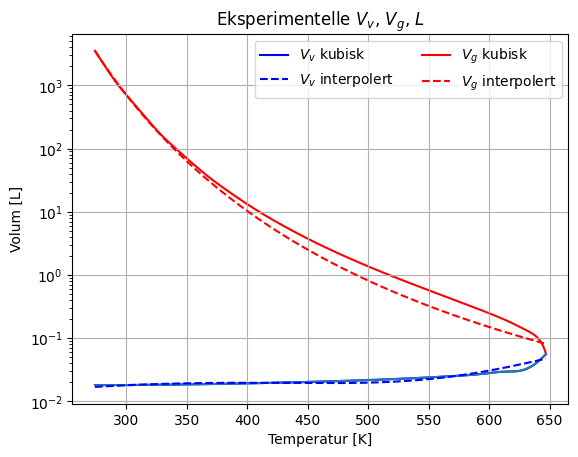

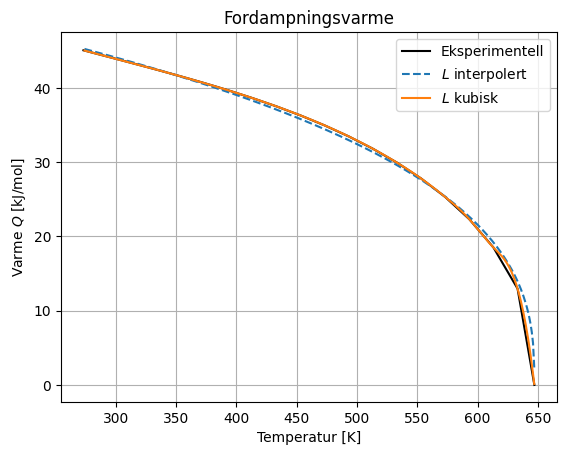

In [15]:
Vv_cubic = scipy.interpolate.CubicSpline(T_Vv_exp, Vv_exp)
Vg_cubic = scipy.interpolate.CubicSpline(T_Vg_exp, Vg_exp)
L_cubic = scipy.interpolate.CubicSpline(T_L_exp, L_exp)

plt.plot(temp_arr, Vv_cubic(temp_arr))

plt.semilogy(temp_arr, Vv_cubic(temp_arr), label=r'$V_v$ kubisk', c='b', ls='-', zorder=1)
plt.semilogy(temp_arr, Vv(temp_arr), label=r"$V_v$ interpolert", c='b', ls='--', zorder=2)

#Plotter spesifikt volum av vanndamp som funksjon av temperatur
plt.semilogy(temp_arr, Vg_cubic(temp_arr), label=r'$V_g$ kubisk', c='r', ls='-', zorder=1)
plt.semilogy(temp_arr, Vg(temp_arr), label=r"$V_g$ interpolert", c='r', ls='--', zorder=2)

plt.xlabel("Temperatur [K]")
plt.ylabel("Volum [L]")
plt.title('Eksperimentelle $V_v$, $V_g$, $L$')
plt.legend(ncol=2)
plt.grid()
plt.show()

plt.plot(T_L_exp, L_exp*1e-3, label="Eksperimentell", color='k')
plt.plot(temp_arr, L(temp_arr)*1e-3, label=r"$L$ interpolert", ls='--')
plt.plot(temp_arr, L_cubic(temp_arr)*1e-3, label=r'$L$ kubisk')
plt.title("Fordampningsvarme")
plt.xlabel("Temperatur [K]")
plt.ylabel("Varme $Q$ [kJ/mol]")
plt.legend()
plt.grid()
plt.show()


Vi observerer at interpolasjonen som bruker kubiske spliner gir en kurve som i større grad samsvarer med de eksperimentelle verdiene.
- Hvilken type interpolasjon mener dere passer best til hvert av datasettene?

### 2e

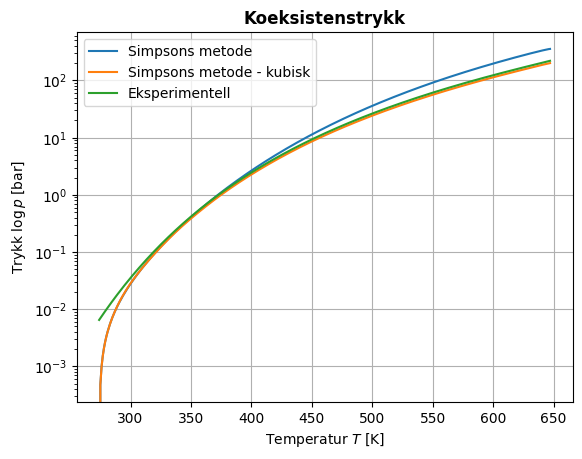

In [16]:
def dp_cubic(T):
    return 1e3 * L_cubic(T) / (T * (Vg_cubic(T) - Vv_cubic(T)))

p_clapeyron_cubic = [simpsons(dp_cubic, 274, t)*1e-5 for t in temp_arr]  # [bar]

plt.semilogy(temp_arr, p_clapeyron, label="Simpsons metode")
plt.semilogy(temp_arr, p_clapeyron_cubic, label="Simpsons metode - kubisk")
plt.semilogy(temp_arr, vapor_pressure_exp*1e-5, label='Eksperimentell')
plt.xlabel('Temperatur $T$ [K]')
plt.ylabel('Trykk $\log p$ [bar]')
plt.title('Koeksistenstrykk', weight='bold')
plt.legend()
plt.grid()
plt.show()

- Diskuter hvilke faktorer som kan forklare avviket mellom grafene
- Potensielle feil i numerikken
- Feil i eksperimentell måledata
- Interpolasjon